In [1]:
include("main.jl")
using PyCall
using CairoMakie
sepsis_gym = pyimport("custom_sepsis")
using Statistics


In [2]:
ts = Dict(
    :Simple => [sepsis_gym.DirThompsonSampling.load_json("json/dirichlet/ts/Simple-$i.json") for i in 0:2],
    :Medium => [sepsis_gym.DirThompsonSampling.load_json("json/dirichlet/ts/Medium-$i.json") for i in 0:2],
    :None => [sepsis_gym.DirThompsonSampling.load_json("json/dirichlet/ts/None-$i.json") for i in 0:2],
    :Softmax => [load_jld("data/mcmc/runs/SoftmaxPPL-$i.jld")  for i in 1:3],
    :SimplePPL => [load_jld("data/mcmc/runs/SimplePPL-$i.jld")  for i in 1:3]
)

Dict{Symbol, Vector} with 5 entries:
  :Softmax   => RunData[RunData("SoftmaxPPL-1", :Softmax, ModelData(DynamicChoi…
  :None      => PyObject[PyObject <custom_sepsis.models.dirichlet.evaluate.thom…
  :Medium    => PyObject[PyObject <custom_sepsis.models.dirichlet.evaluate.thom…
  :SimplePPL => RunData[RunData("SimplePPL-1", :SimplePPL, ModelData(DynamicCho…
  :Simple    => PyObject[PyObject <custom_sepsis.models.dirichlet.evaluate.thom…

In [4]:
dqn = load_dqn_from_json("json/dqn/DQN-mean-rewards.json")

DQNType([-0.800000011920929, -0.6000000238418579, -0.7400000095367432, -0.7599999904632568, -0.7200000286102295, -0.6600000262260437, -0.6600000262260437, -0.7200000286102295, -0.5799999833106995, -0.699999988079071  …  -0.11999999731779099, -0.23999999463558197, -0.30000001192092896, -0.2199999988079071, -0.20000000298023224, -0.07999999821186066, 0.0, -0.1599999964237213, -0.03999999910593033, -0.25999999046325684], [0.4000000059604645, 0.5656853914260864, 0.5219195485115051, 0.5122499465942383, 0.4489988684654236, 0.5517245531082153, 0.47370877861976624, 0.4489988684654236, 0.5688584446907043, 0.5  …  0.7110555768013, 0.7631514072418213, 0.6708203554153442, 0.5758472084999084, 0.6633249521255493, 0.6584831476211548, 0.800000011920929, 0.7310267090797424, 0.6916646361351013, 0.6575713157653809], "DQN", Dict("description" => "Mean rewards for DQN over 50 runs with 13562 episode interactions"))

In [10]:
function plot_mean_rewards(ts, batch_size, types=[:SimplePPL, :Softmax, :Simple, :Medium, :None], dqn=nothing, window_size=5, x_lim=nothing, )
    fig = Figure(resolution=(700, 500))  
    ax = Axis(fig[1, 1], xlabel = "Number of Episodes", ylabel = "Mean Reward Across 100'000 Episodes", title = "Mean Rewards for Thompson Sampling with Batch Size $batch_size")

    # Data storage for accessing smoothed values later
    data = Dict()

    ks = []
    for (i, type) in enumerate(types)
        if isempty(ts[type])
            continue
        end

        all_keys = [sort(collect(keys(model.mean_rewards))) for model in ts[type]]
        min_keys = minimum(length.(all_keys))
        ks = all_keys[1][1:min_keys]
        filled_rewards = []
        all_rewards = []
        for model in ts[type]
            rewards = [model.mean_rewards[1]]
            for i in 2:min_keys
                key = all_keys[1][i]
                mult_factor = key - all_keys[1][i-1]
                push!(rewards, fill(model.mean_rewards[key], mult_factor)...)
            end
            push!(all_rewards, [model.mean_rewards[k] for k in ks])
            push!(filled_rewards, rewards)
            lines!(ax, Float64.(rewards), color=(colors_dict[type], 0.2))
        end
        mean_filled_rewards = mean(filled_rewards)
        mean_rewards = mean(all_rewards)
        smoothed_mean_rewards = moving_avg(mean_rewards, window_size)
        lines!(ax, ks, Float64.(smoothed_mean_rewards), color=colors_dict[type], linewidth=1.5, label=label_dict[type])

        std_rewards = std(all_rewards)
        smoothed_std_rewards = Float64.(moving_avg(std_rewards, window_size))
        low = smoothed_mean_rewards .- smoothed_std_rewards
        high = smoothed_mean_rewards .+ smoothed_std_rewards
        band!(ax, Float64.(ks), low, high, color=(colors_dict[type], 0.2))

        # Save smoothed data for future use
        data[type] = mean_filled_rewards
    end
    len = maximum(length(data[type]) for type in types)

    lines!(ax, 1:len, fill(random_mean, len), color=:black, linestyle=:dash, label="Random Policy")
    if dqn != nothing
        add_dqn!(ax, dqn, Int(10000/window_size))
        data[:DQN] = dqn.mean_rewards
    end
    axislegend(ax, position=(:right, :bottom))

    if x_lim != nothing
        xlims!(ax, 0, x_lim)
    end
    
    ylims!(ax, -1, 0)
    save("ts.png", fig)
    display(fig)

    return data
end


plot_mean_rewards (generic function with 5 methods)

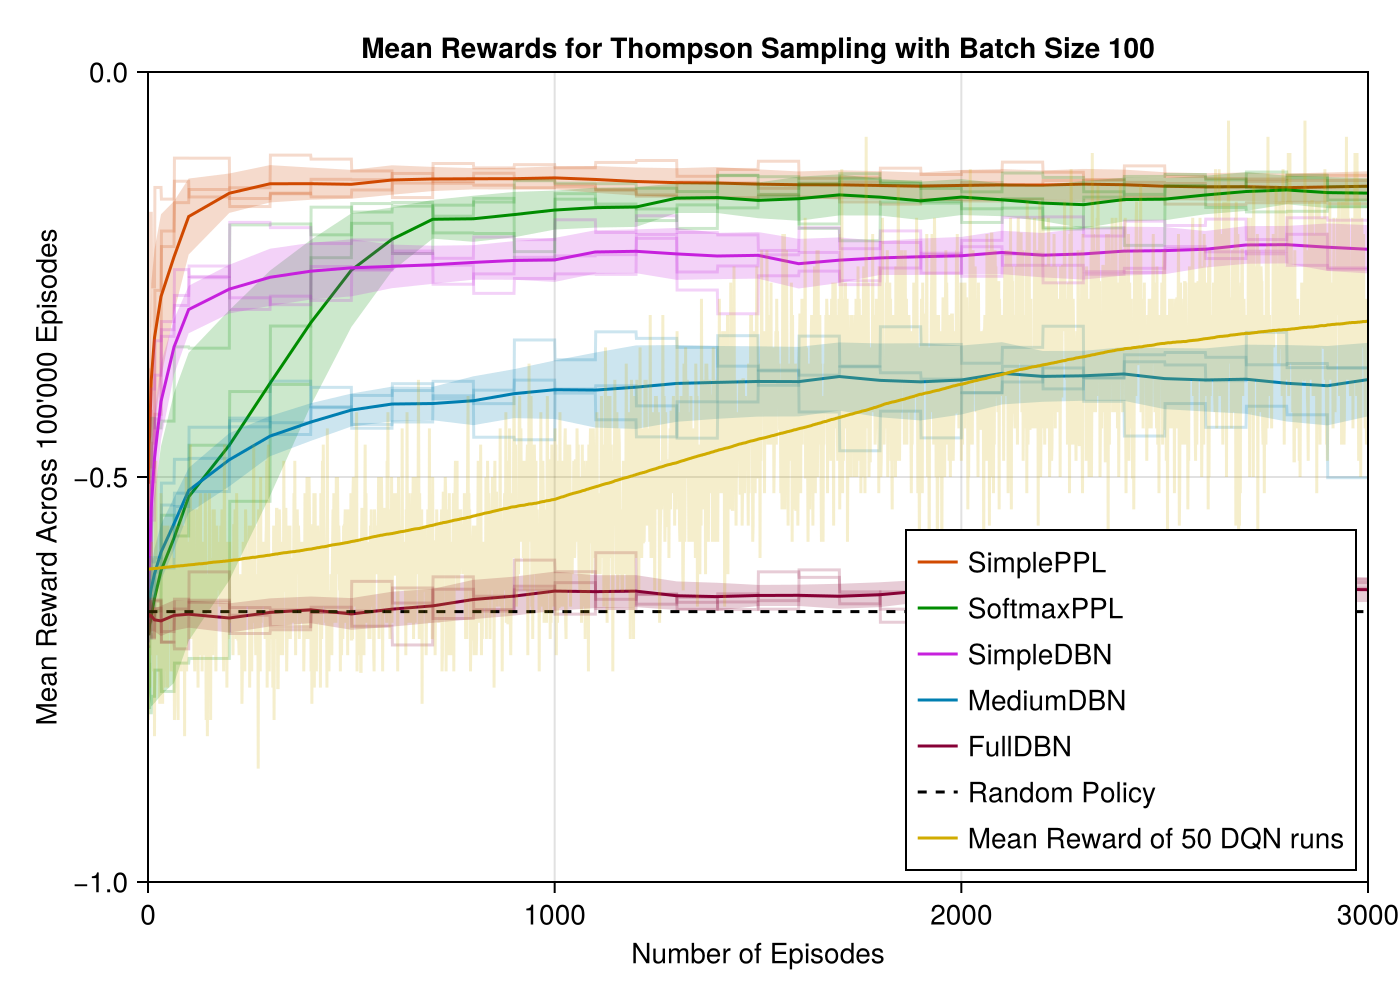

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/luisastue/.julia/packages/Makie/Y3ABD/src/scenes.jl:238


Dict{Any, Any} with 6 entries:
  :DQN       => [-0.8, -0.6, -0.74, -0.76, -0.72, -0.66, -0.66, -0.72, -0.58, -…
  :Softmax   => [-0.66947, -0.68896, -0.71846, -0.71846, -0.71067, -0.71067, -0…
  :None      => [-0.658183, -0.67427, -0.668743, -0.668743, -0.675217, -0.67521…
  :Medium    => [-0.671667, -0.64189, -0.64451, -0.64451, -0.65426, -0.65426, -…
  :SimplePPL => [-0.624323, -0.453003, -0.38704, -0.38704, -0.38049, -0.38049, …
  :Simple    => [-0.671597, -0.62753, -0.618317, -0.618317, -0.584957, -0.58495…

In [46]:
# mean_rewards = plot_mean_rewards(ts, 100)
mean_rewards = plot_mean_rewards(ts, 100, [:SimplePPL, :Softmax, :Simple, :Medium, :None], dqn, 5, 4000)


In [2]:
ts_every = Dict(
    :Simple => [sepsis_gym.DirThompsonSampling.load_json("json/dirichlet/ts/Simple-every-$i.json") for i in 1:3],
    :Medium => [sepsis_gym.DirThompsonSampling.load_json("json/dirichlet/ts/Medium-every-$i.json") for i in 1:3],
    :Softmax => [load_jld("data/mcmc/runs/SoftmaxPPL-every-$i.jld")  for i in 1:3],
    :SimplePPL => [load_jld("data/mcmc/runs/SimplePPL-every-$i.jld")  for i in 1:3]
)

Dict{Symbol, Vector} with 4 entries:
  :Softmax   => RunData[RunData("SoftmaxPPL-every-1", :Softmax, ModelData(Dynam…
  :Medium    => PyObject[PyObject <custom_sepsis.models.dirichlet.evaluate.thom…
  :SimplePPL => RunData[RunData("SimplePPL-every-1", :SimplePPL, ModelData(Dyna…
  :Simple    => PyObject[PyObject <custom_sepsis.models.dirichlet.evaluate.thom…

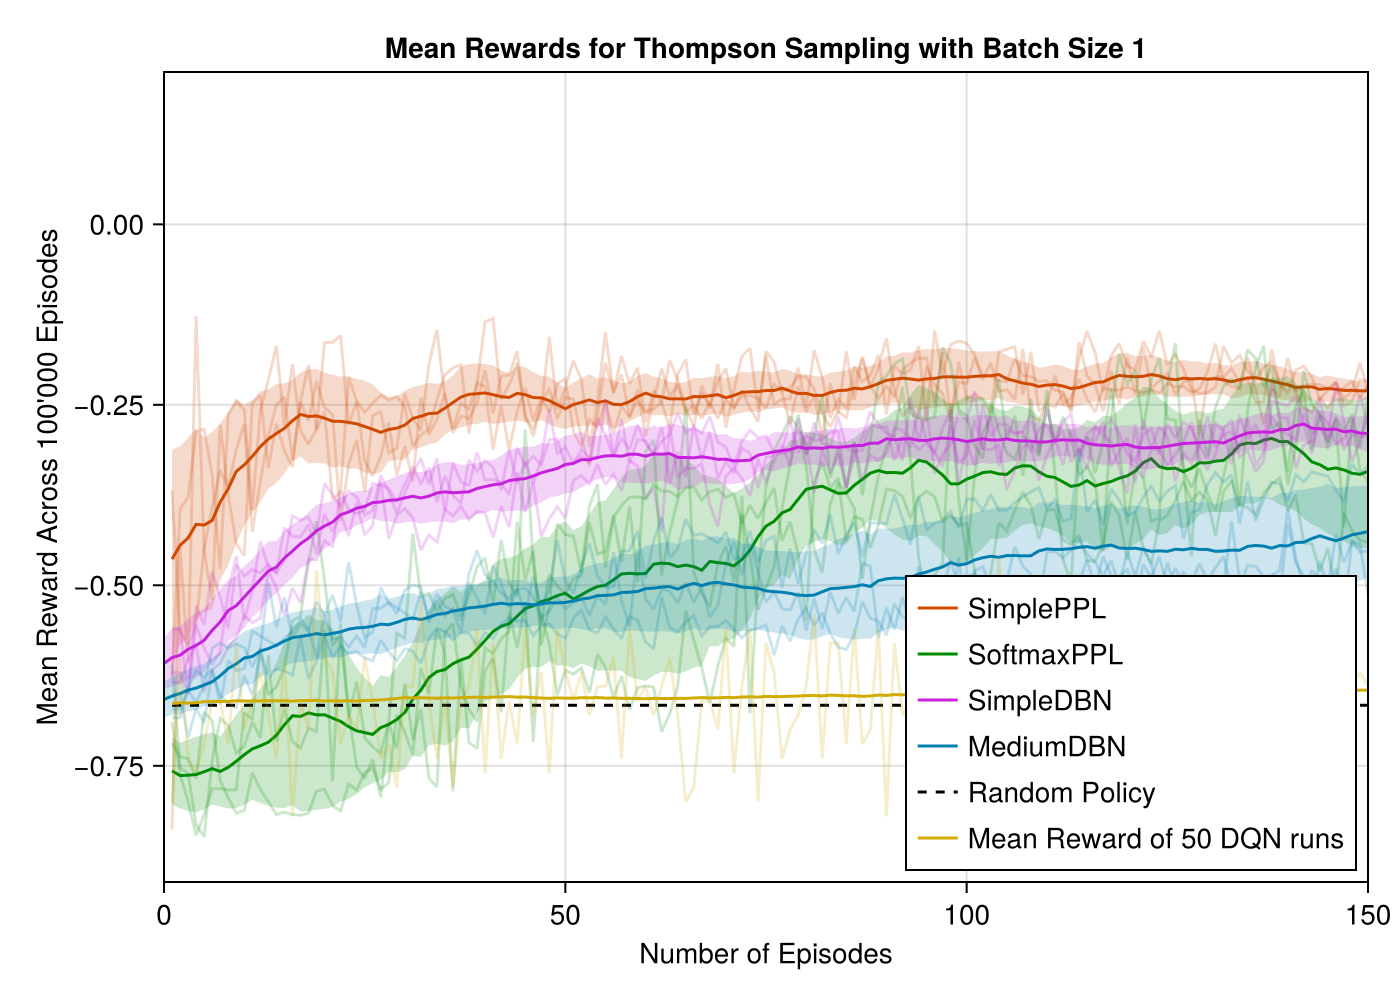

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/luisastue/.julia/packages/Makie/Y3ABD/src/scenes.jl:238


Dict{Any, Any} with 5 entries:
  :DQN       => [-0.8, -0.6, -0.74, -0.76, -0.72, -0.66, -0.66, -0.72, -0.58, -…
  :Softmax   => [-0.67245, -0.750493, -0.7667, -0.81518, -0.780507, -0.73752, -…
  :Medium    => [-0.668417, -0.668417, -0.666513, -0.650337, -0.65212, -0.60715…
  :SimplePPL => [-0.611203, -0.467777, -0.522927, -0.32263, -0.39457, -0.41968,…
  :Simple    => [-0.60532, -0.60532, -0.634067, -0.55527, -0.596587, -0.569227,…

In [22]:
plot_mean_rewards(ts_every, 1, [:SimplePPL, :Softmax, :Simple, :Medium], dqn, 10, 150)


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Y3ABD/src/scenes.jl:238


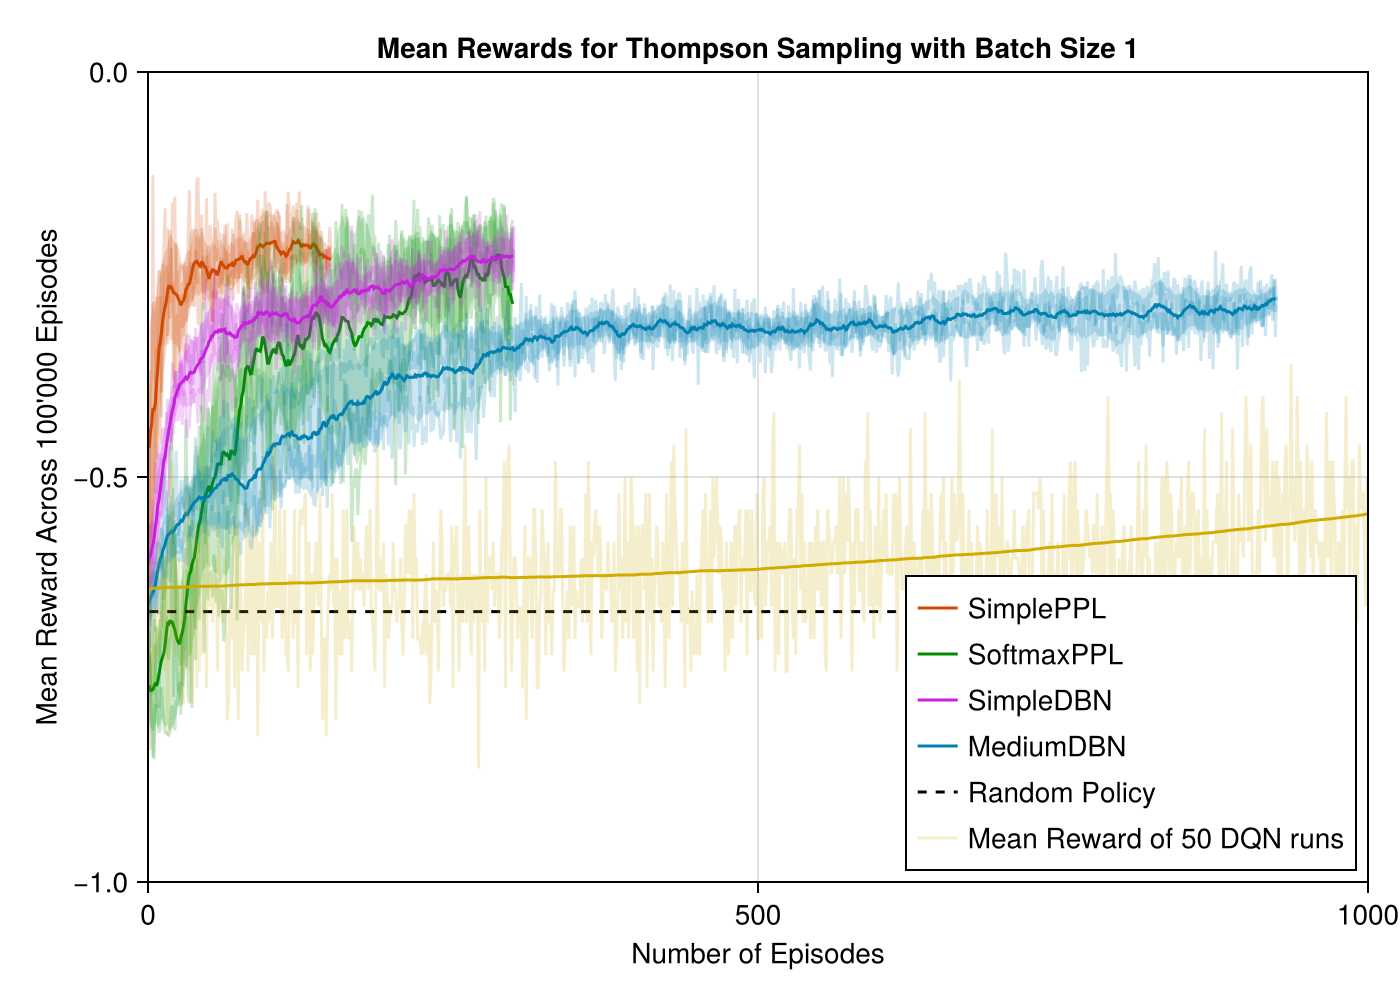

Dict{Any, Any} with 5 entries:
  :DQN       => [-0.8, -0.6, -0.74, -0.76, -0.72, -0.66, -0.66, -0.72, -0.58, -…
  :Softmax   => [-0.67245, -0.750493, -0.7667, -0.81518, -0.780507, -0.73752, -…
  :Medium    => [-0.668417, -0.668417, -0.666513, -0.650337, -0.65212, -0.60715…
  :SimplePPL => [-0.611203, -0.467777, -0.522927, -0.32263, -0.39457, -0.41968,…
  :Simple    => [-0.60532, -0.60532, -0.634067, -0.55527, -0.596587, -0.569227,…

In [11]:
mean_rewards_every = plot_mean_rewards(ts_every, 1, [:SimplePPL, :Softmax, :Simple, :Medium], dqn, 10, 1000)


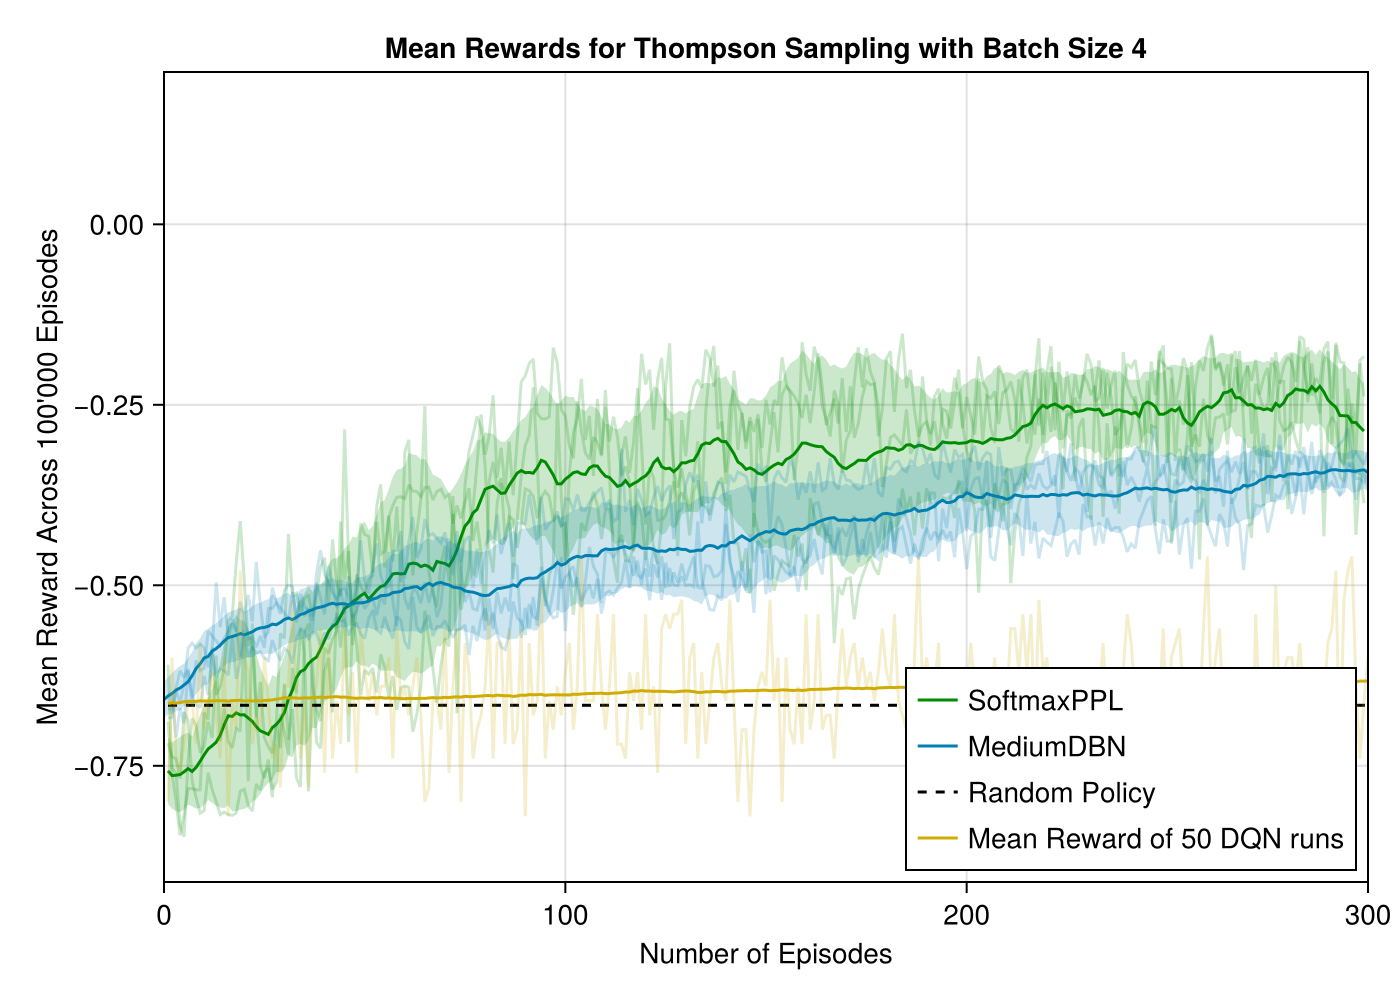

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/luisastue/.julia/packages/Makie/Y3ABD/src/scenes.jl:238


Dict{Any, Any} with 3 entries:
  :Softmax => [-0.67245, -0.750493, -0.7667, -0.81518, -0.780507, -0.73752, -0.…
  :Medium  => [-0.668417, -0.668417, -0.666513, -0.650337, -0.65212, -0.60715, …
  :DQN     => [-0.8, -0.6, -0.74, -0.76, -0.72, -0.66, -0.66, -0.72, -0.58, -0.…

In [24]:
plot_mean_rewards(ts_every, 4, [ :Softmax :Medium], dqn, 10, 300)


In [6]:
type_labels = Dict(
    :Softmax => "\\mathsf{SoftmaxPPL}",
    :None => "\\mathsf{FullDBN}",
    :Medium => "\\mathsf{MediumDBN}",
    :DQN => "\\mathsf{DQN}",
    :Simple => "\\mathsf{SimpleDBN}",
    :SimplePPL => "\\mathsf{SimplePPL}"
)

Dict{Symbol, String} with 6 entries:
  :SimplePPL => "\\mathsf{SimplePPL}"
  :Softmax   => "\\mathsf{SoftmaxPPL}"
  :None      => "\\mathsf{FullDBN}"
  :Medium    => "\\mathsf{MediumDBN}"
  :DQN       => "\\mathsf{DQN}"
  :Simple    => "\\mathsf{SimpleDBN}"

In [7]:
function generate_latex_table(cumsums, checkpoints, type_labels, types)
    table = "\\begin{tabular}{|l|" * "r|"^length(checkpoints) * "}\n\\hline\n"
    table *= " & " * join(["\$" * string(ch) * "\$" for ch in checkpoints], " & ") * " \\\\ \\hline\n"

    # Collect all column values to compute min and max later
    column_values = [Float64[] for _ in checkpoints]

    for (_, values) in cumsums
        for (j, checkpoint) in enumerate(checkpoints)
            if checkpoint <= length(values)
                push!(column_values[j], round(values[checkpoint], digits=2))
            else
                push!(column_values[j], NaN)
            end
        end
    end

    # Identify min and max for each column
    column_mins = [isempty(col[.!isnan.(col)]) ? NaN : minimum(col[.!isnan.(col)]) for col in column_values]
    column_maxs = [isempty(col[.!isnan.(col)]) ? NaN : maximum(col[.!isnan.(col)]) for col in column_values]


    for key in types
        label = type_labels[key]
        # Generate row data, only include values where checkpoints are valid
        row_data = []
        for (j, checkpoint) in enumerate(checkpoints)
            if checkpoint <= length(cumsums[key])
                value = round(cumsums[key][checkpoint], digits=2)
                if value == column_mins[j]
                    push!(row_data, "\\color{red}{\$" * string(value) * "\$}")
                elseif value == column_maxs[j]
                    push!(row_data, "\\color{blue}{\$" * string(value) * "\$}")
                else
                    push!(row_data, "\$" * string(value) * "\$")
                end
            else
                push!(row_data, "-")
            end
        end
        table *= "\$" * label * "\$ & " * join(row_data, " & ") * " \\\\ \n"
    end

    table *= "\\hline \n\\end{tabular}\n"
    return table
end


generate_latex_table (generic function with 1 method)

In [47]:
cumsums = Dict(type => accumulate(.+, mean_rewards[type]) for type in keys(mean_rewards))

Dict{Symbol, Vector{Float64}} with 6 entries:
  :Simple    => [-0.671597, -1.29913, -1.91744, -2.53576, -3.12072, -3.70567, -…
  :Softmax   => [-0.66947, -1.35843, -2.07689, -2.79535, -3.50602, -4.21669, -4…
  :None      => [-0.658183, -1.33245, -2.0012, -2.66994, -3.34516, -4.02037, -4…
  :Medium    => [-0.671667, -1.31356, -1.95807, -2.60258, -3.25684, -3.9111, -4…
  :DQN       => [-0.8, -1.4, -2.14, -2.9, -3.62, -4.28, -4.94, -5.66, -6.24, -6…
  :SimplePPL => [-0.624323, -1.07733, -1.46437, -1.85141, -2.2319, -2.61239, -2…

In [12]:
cumsums_every = Dict(type => accumulate(.+, mean_rewards_every[type]) for type in keys(mean_rewards_every))


Dict{Symbol, Vector{Float64}} with 5 entries:
  :Simple    => [-0.60532, -1.21064, -1.84471, -2.39998, -2.99656, -3.56579, -4…
  :Softmax   => [-0.67245, -1.42294, -2.18964, -3.00482, -3.78533, -4.52285, -5…
  :Medium    => [-0.668417, -1.33683, -2.00335, -2.65368, -3.3058, -3.91295, -4…
  :DQN       => [-0.8, -1.4, -2.14, -2.9, -3.62, -4.28, -4.94, -5.66, -6.24, -6…
  :SimplePPL => [-0.611203, -1.07898, -1.60191, -1.92454, -2.31911, -2.73879, -…

In [50]:
print(generate_latex_table(cumsums, [10,100,150,400,1000,5000], type_labels, [:SimplePPL, :Softmax, :Simple, :Medium, :None, :DQN]))

\begin{tabular}{|l|r|r|r|r|r|r|}
\hline
 & $10$ & $100$ & $150$ & $400$ & $1000$ & $5000$ \\ \hline
$\mathsf{SimplePPL}$ & \color{blue}{$-4.18$} & \color{blue}{$-21.95$} & \color{blue}{$-28.71$} & \color{blue}{$-64.39$} & \color{blue}{$-143.44$} & - \\ 
$\mathsf{SoftmaxPPL}$ & $-6.89$ & $-58.76$ & $-84.19$ & $-176.29$ & $-286.8$ & - \\ 
$\mathsf{SimpleDBN}$ & $-5.84$ & $-34.65$ & $-47.08$ & $-109.97$ & $-251.98$ & \color{blue}{$-1130.11$} \\ 
$\mathsf{MediumDBN}$ & $-6.49$ & $-56.14$ & $-80.03$ & $-189.2$ & $-432.69$ & $-1962.59$ \\ 
$\mathsf{FullDBN}$ & $-6.74$ & \color{red}{$-68.02$} & \color{red}{$-100.08$} & \color{red}{$-267.57$} & \color{red}{$-659.67$} & \color{red}{$-3209.81$} \\ 
$\mathsf{DQN}$ & \color{red}{$-6.94$} & $-66.38$ & $-98.38$ & $-256.82$ & $-613.88$ & $-1930.9$ \\ 
\hline 
\end{tabular}


In [13]:
print(generate_latex_table(cumsums_every, [10,100, 150, 400], type_labels, [:SimplePPL, :Softmax, :Simple, :Medium, :DQN]))


\begin{tabular}{|l|r|r|r|r|}
\hline
 & $10$ & $100$ & $150$ & $400$ \\ \hline
$\mathsf{SimplePPL}$ & \color{blue}{$-4.1$} & \color{blue}{$-26.12$} & \color{blue}{$-37.04$} & - \\ 
$\mathsf{SoftmaxPPL}$ & \color{red}{$-7.54$} & $-53.56$ & $-70.35$ & - \\ 
$\mathsf{SimpleDBN}$ & $-5.72$ & $-37.16$ & $-51.97$ & - \\ 
$\mathsf{MediumDBN}$ & $-6.4$ & $-53.47$ & $-75.86$ & \color{blue}{$-164.83$} \\ 
$\mathsf{DQN}$ & $-6.94$ & \color{red}{$-66.38$} & \color{red}{$-98.38$} & \color{red}{$-256.82$} \\ 
\hline 
\end{tabular}
